## Import Model Class

In [2]:
import vgg16

Instructions for updating:
non-resource variables are not supported in the long term


### Import other libraries

In [26]:
from IPython.display import Image, display
import cv2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import PIL.Image 
import download
import os

In [4]:
tf.__version__

'2.1.0'

## Download Convolutional Model

In [ ]:
vgg16.maybe_download()

## Helper functions for image manipulation

In [9]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)
    
    if max_size is not None:
        factor = max_size/np.max(image.size)
        
        size = np.array(image.size)*factor
        size = size.astype(int)
        image = image.resize(size, PIL.Image.LANCZOS)
        
    return np.float32(image)

In [10]:
def save_image(image, filename):
    image = np.clip(image, 0.0, 255.0)
    
    with open(filename, "wb") as file:
        PIL.Image.fromarray(image).save(file,'jpeg')
        

In [11]:
def plot_image_big(image):
    image = np.clip(image, 0.0, 255.0)
    
    image = image.astype(int)
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    plt.imshow(image);
    plt.xticks([]),plt.yticks([])
    #cv2.imshow("Final Art",image)
    
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    #display(PIL.Image.fromarray(image))
    

In [12]:
def plot_images(content_image, style_image, mixed_image):
    fig, axes = plt.subplots(1,3, figsize = (10,10))
    
    smooth = True 
    
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'
        
    ax = axes.flat[0]
    ax.imshow(content_image/255.0, interpolation = interpolation)
    ax.set_xlabel("Content")
    
    ax = axes.flat[1]
    ax.imshow(style_image/255.0, interpolation = interpolation)
    ax.set_xlabel("Style")
    
    ax = axes.flat[2]
    ax.imshow(mixed_image/255.0, interpolation = interpolation)
    ax.set_xlabel("Mixed")
    
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

## LOSS FUNCTIONS

In [13]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a-b))

### Content Loss

In [14]:
def create_content_loss(session, model, content_image, layer_ids):
    feed_dict = model.create_feed_dict(image = content_image)
    
    layers = model.get_layer_tensors(layer_ids)
    
    values = session.run(layers, feed_dict = feed_dict)
    
    with model.graph.as_default():
        layer_loss = []
        
        for value, layer in zip(values, layers):
            value_const = tf.constant(value)
            
            loss = mean_squared_error(value_const, layer)
            
            layer_loss.append(loss)
            
        total_loss = tf.reduce_mean(layer_loss)
    
    return total_loss

### Gram Matrix

In [15]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    num_channels = int(shape[3])
    
    matrix = tf.reshape(tensor, shape = [-1, num_channels])
    
    gram = tf.matmul(tf.transpose(matrix), matrix)
    
    return gram

### Style Loss 

In [16]:
def create_style_loss(session, model, style_image, layer_ids):
    feed_dict = model.create_feed_dict(image = style_image)

    layers = model.get_layer_tensors(layer_ids)
    
    with model.graph.as_default():
        gram_layers = [gram_matrix(layer) for layer in layers]
    
        values = session.run(gram_layers, feed_dict = feed_dict)
        
        layer_loss = []
        
        for value, gram_layer in zip(values, gram_layers):
            value_const = tf.constant(value)
            
            loss = mean_squared_error(value_const, gram_layer)
            
            layer_loss.append(loss)
        
        total_loss = tf.reduce_mean(layer_loss)
    
    return total_loss
    

### Denoising Loss

In [17]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

### Style Transfer Algorithm

In [18]:
def style_transfer(content_image, style_image, content_layer_ids, style_layer_ids, weight_content = 2.0, weight_style = 5.0, weight_denoise = 0.3, num_iterations = 120, step_size = 10.0):
    
    model = vgg16.VGG16()
    
    session = tf.InteractiveSession(graph = model.graph)
    
    print("Content Layers")
    print(model.get_layer_names(content_layer_ids))
    print()
    
    print("Style Layers")
    print(model.get_layer_names(style_layer_ids))
    print()
    
    loss_content = create_content_loss(session = session, model = model, content_image = content_image, layer_ids = content_layer_ids)
    loss_style = create_style_loss(session = session, model = model, style_image = style_image, layer_ids = style_layer_ids)
    loss_denoise = create_denoise_loss(model = model)
    
    adj_content = tf.Variable(1e-10, name = "adj_content")
    adj_style = tf.Variable(1e-10, name = "adj_style")
    adj_denoise = tf.Variable(1e-10, name= "adj_denoise")
    
    session.run([adj_content.initializer, adj_style.initializer, adj_denoise.initializer])
    
    update_adj_content = adj_content.assign(1.0/(loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0/(loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0/(loss_denoise + 1e-10))
    
    loss_combined = weight_content*loss_content*adj_content + weight_style*loss_style*adj_style + weight_denoise*loss_denoise*adj_denoise
    
    gradient = tf.gradients(loss_combined, model.input)
    
    run_list = [gradient, update_adj_content, update_adj_denoise, update_adj_style]
    
    mixed_image = np.random.rand(*content_image.shape) + 128
    
    for i in range(num_iterations):
        feed_dict = model.create_feed_dict(image = mixed_image)
        
        grad, adj_content_val, adj_style_val, adj_denoise_val = session.run(run_list, feed_dict = feed_dict)
        
        grad = np.squeeze(grad)
        
        step_size_scaled = step_size/(np.std(grad)+1e-8)
        
        mixed_image -= step_size_scaled*grad
        mixed_image = np.clip(mixed_image, 0.0, 255.0)
        print(". ", end="")
        
        if (i%10 == 0) or (i==num_iterations-1):
            print()
            print("Iteration:", i)

            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))
            
            plot_images(content_image = content_image, style_image = style_image, mixed_image = mixed_image)
            
    print()
    print("Final Image: ", type(mixed_image), mixed_image.shape)

    plot_image_big(mixed_image)
    
    session.close()
    
    return mixed_image

## TESTING

In [19]:
content_filename = "images/monroe.jpg"

In [20]:
content_image = load_image(content_filename, max_size = 500)

In [21]:
style_filename = "images/flower.jpg"

In [22]:
style_image = load_image(style_filename, max_size = 500)

In [23]:
content_layer_ids = [2,3]

In [24]:
style_layer_ids = list(range(13))

Instructions for updating:
Use tf.gfile.GFile.
Content Layers
['conv2_1/conv2_1', 'conv2_2/conv2_2']

Style Layers
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 1.29e-10, Style: 2.50e-06, Denoise: 3.81e-30


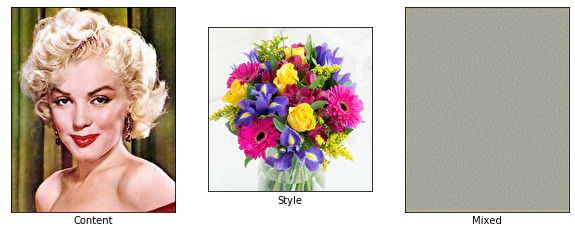

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 2.63e-10, Style: 1.06e-07, Denoise: 2.67e-29


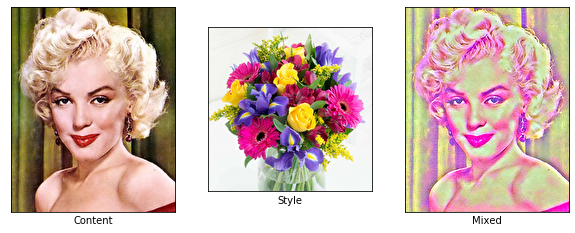

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 1.38e-10, Style: 1.09e-07, Denoise: 9.74e-29


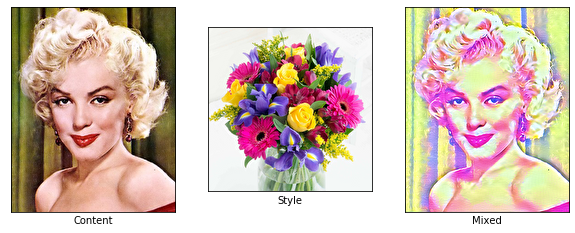

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 1.51e-10, Style: 1.06e-07, Denoise: 1.77e-28


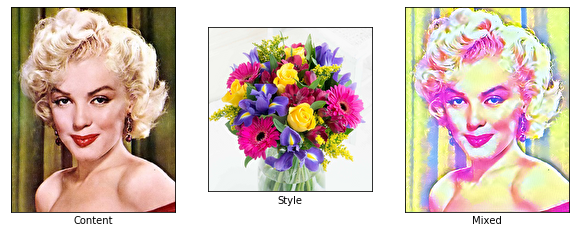

. 

KeyboardInterrupt: 

In [25]:
%%time
style_transfer(content_image, style_image, content_layer_ids = content_layer_ids, style_layer_ids = style_layer_ids, num_iterations=60, step_size = 10.0)